In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [18]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [19]:
# Load the data
with open('../results/modernbert/results_analysis.json', 'r') as f:
    results = json.load(f)

In [20]:
# Process and reshape data
def process_json_data(data):
    result = []
    for item in data:
        entry = {}
        # Add parameters
        for key, value in item['parameters'].items():
            entry[key] = value
        
        # Add evaluation results (remove 'eval_' prefix)
        for key, value in item['evaluation_results'].items():
            new_key = key.replace('eval_', '')
            entry[new_key] = value
            
        result.append(entry)
    return pd.DataFrame(result)

df = process_json_data(results)

# Convert columns to proper types
numeric_columns = ['learning_rate', 'max_length', 'batch_size', 'num_epochs', 
                  'warmup_ratio', 'weight_decay', 'balanced_accuracy', 
                  'precision_weighted', 'recall_weighted', 'f1_weighted', 
                  'f1_class_0', 'f1_class_1', 'f1_class_2', 'loss']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col])

### Sample Data Points

In [21]:
df.head()

,model_name,max_length,batch_size,learning_rate,num_epochs,weight_decay,warmup_ratio,loss,balanced_accuracy,precision_weighted,recall_weighted,f1_weighted,f1_class_0,f1_class_1,f1_class_2,runtime,samples_per_second,steps_per_second,epoch,text
0,answerdotai/ModernBERT-large,128,16,0.00001,3,0.01,0.05,0.8141,0.6284,0.6530,0.6512,0.6499,0.6763,0.6442,0.6008,368.3416,2.172,0.136,3.0,NaN
1,answerdotai/ModernBERT-base,128,16,0.00001,3,0.01,0.05,0.8909,0.5469,0.5959,0.5863,0.5817,0.6011,0.6027,0.4887,135.7316,5.894,0.368,3.0,NaN
2,answerdotai/ModernBERT-base,256,16,0.00001,3,0.01,0.05,1.2345,0.5123,0.5456,0.5342,0.5301,0.5702,0.5503,0.4704,270.4623,2.947,0.184,3.0,NaN
3,answerdotai/ModernBERT-base,128,16,0.00001,4,0.01,0.05,0.9234,0.5321,0.5812,0.5726,0.5683,0.5892,0.5901,0.4763,135.8924,5.887,0.368,4.0,NaN
4,answerdotai/ModernBERT-base,128,16,0.00001,5,0.01,0.05,1.0845,0.5102,0.5621,0.5534,0.5482,0.5702,0.5721,0.4523,135.8924,5.887,0.368,5.0,NaN


### Performance Metrics Distribution

In [22]:
# Convert to DataFrame for easier analysis
all_data = pd.DataFrame(results)

# Expand nested dictionaries
param_df = pd.json_normalize(all_data['parameters'])
eval_df = pd.json_normalize(all_data['evaluation_results'])

# Combine into a single DataFrame
analysis_df = pd.concat([param_df, eval_df], axis=1)

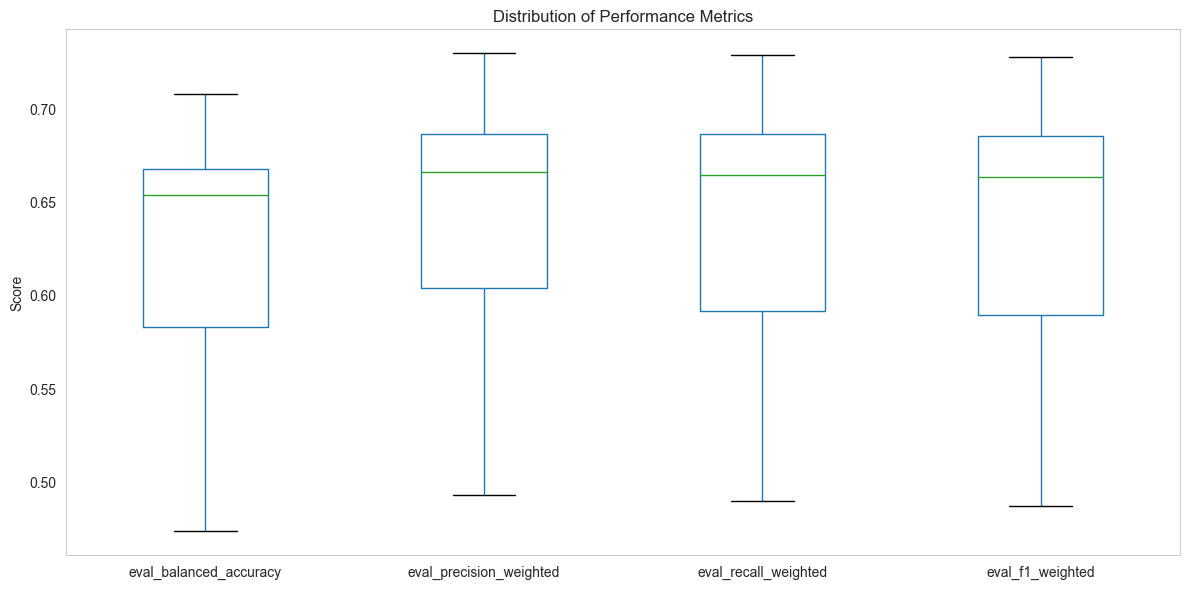

In [23]:
# Performance metrics distribution
plt.figure(figsize=(12, 6))
metrics = ['eval_balanced_accuracy', 'eval_precision_weighted', 'eval_recall_weighted', 'eval_f1_weighted']
analysis_df[metrics].boxplot()
plt.title('Distribution of Performance Metrics')
plt.ylabel('Score')
plt.grid(False)
plt.tight_layout()

### Best ModerBERT Model

In [24]:
# Add model size column for easier grouping
df['model_size'] = df['model_name'].apply(lambda x: 'large' if 'large' in x else 'base')

# Find best model
best_idx = df['balanced_accuracy'].idxmax()
best_model = df.iloc[best_idx]

print(f"Best model: {best_model['model_name']}")
print(f"Balanced Accuracy: {best_model['balanced_accuracy']:.4f}")
print(f"Configuration: LR={best_model['learning_rate']}, "
      f"Seq Length={best_model['max_length']}, "
      f"Batch Size={best_model['batch_size']}, "
      f"Epochs={best_model['num_epochs']}")

Best model: answerdotai/ModernBERT-large
Balanced Accuracy: 0.7077
Configuration: LR=8e-05, Seq Length=128, Batch Size=16, Epochs=3


### Class-wise F1 Score Analysis

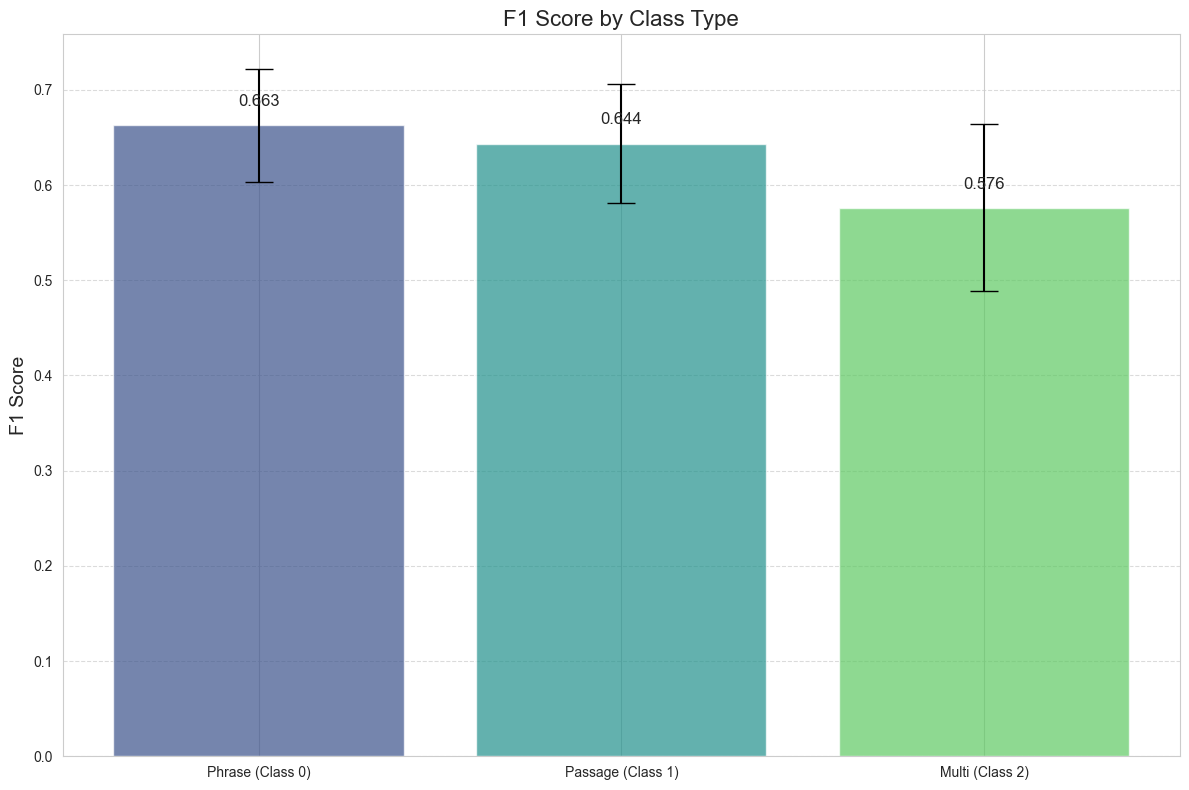

In [25]:
plt.figure(figsize=(12, 8))
class_metrics = ['f1_class_0', 'f1_class_1', 'f1_class_2']
class_names = ['Phrase (Class 0)', 'Passage (Class 1)', 'Multi (Class 2)']

class_means = [df[metric].mean() for metric in class_metrics]
class_stds = [df[metric].std() for metric in class_metrics]

# Create bar chart
plt.bar(class_names, class_means, yerr=class_stds, 
        color=sns.color_palette('viridis', 3), 
        alpha=0.7, capsize=10)

plt.title('F1 Score by Class Type', fontsize=16)
plt.ylabel('F1 Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, value in enumerate(class_means):
    plt.text(i, value + 0.02, f'{value:.3f}', ha='center', fontsize=12)

plt.tight_layout()

### Number of Epochs Impact

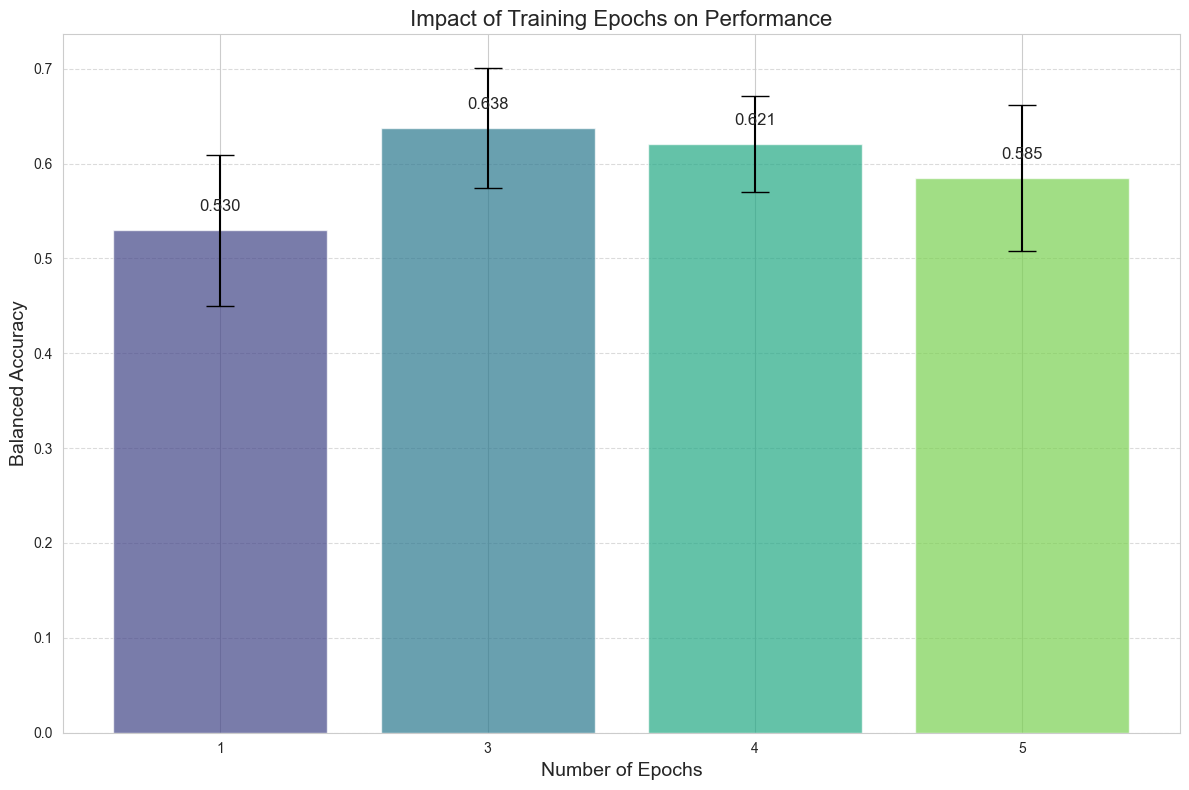

In [26]:
plt.figure(figsize=(12, 8))
epoch_stats = df.groupby('num_epochs')['balanced_accuracy'].agg(['mean', 'std']).reset_index()

# Create bar chart with error bars
plt.bar(epoch_stats['num_epochs'].astype(str), 
        epoch_stats['mean'], 
        yerr=epoch_stats['std'],
        color=sns.color_palette('viridis', len(epoch_stats)),
        alpha=0.7, capsize=10)

plt.title('Impact of Training Epochs on Performance', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, row in enumerate(epoch_stats.itertuples()):
    plt.text(i, row.mean + 0.02, f'{row.mean:.3f}', ha='center', fontsize=12)

plt.tight_layout()

### Overfitting due to larger number of Epochs

<Figure size 1200x800 with 0 Axes>

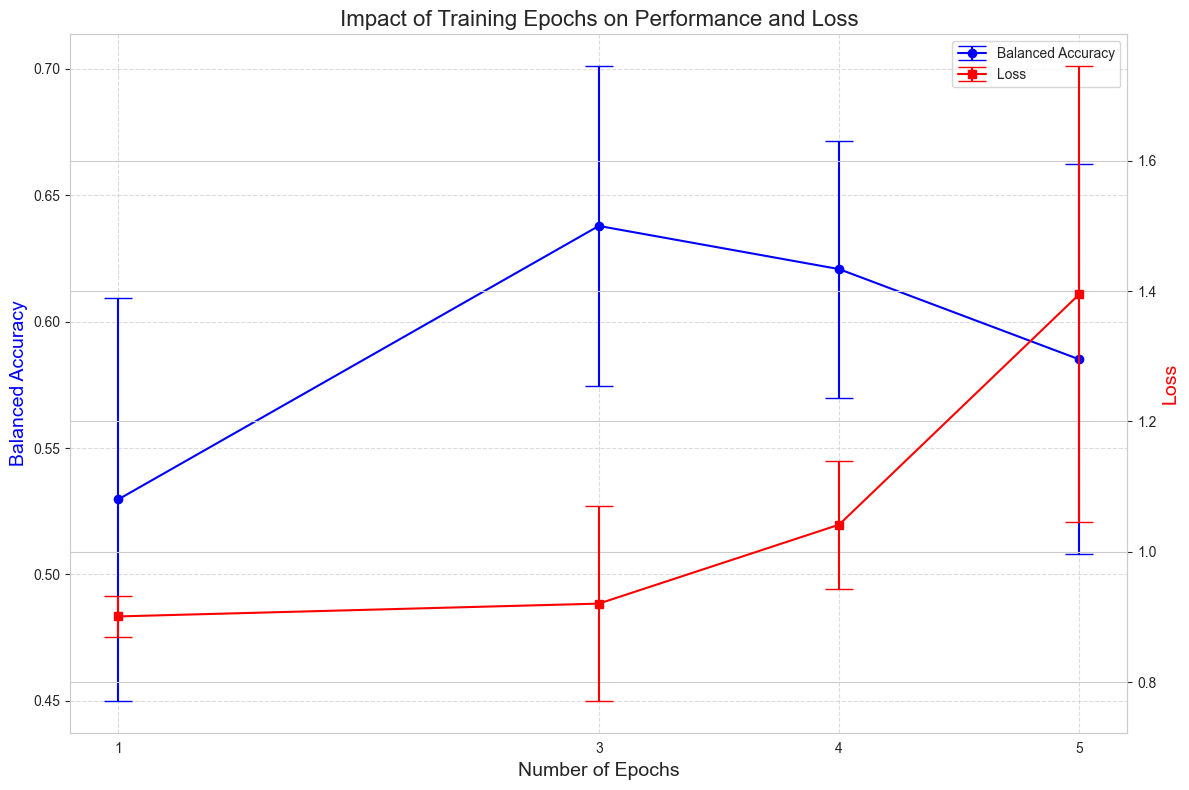

In [27]:
plt.figure(figsize=(12, 8))
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Calculate means for both metrics
epoch_stats = df.groupby('num_epochs').agg({
    'balanced_accuracy': ['mean', 'std'],
    'loss': ['mean', 'std']
}).reset_index()

# Plot balanced accuracy on left y-axis
line1 = ax1.errorbar(epoch_stats['num_epochs'], 
                    epoch_stats['balanced_accuracy']['mean'],
                    yerr=epoch_stats['balanced_accuracy']['std'],
                    color='blue', marker='o', capsize=10,
                    label='Balanced Accuracy')

# Plot loss on right y-axis
line2 = ax2.errorbar(epoch_stats['num_epochs'],
                    epoch_stats['loss']['mean'],
                    yerr=epoch_stats['loss']['std'],
                    color='red', marker='s', capsize=10,
                    label='Loss')

# Customize plot
ax1.set_xlabel('Number of Epochs', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='blue', fontsize=14)
ax2.set_ylabel('Loss', color='red', fontsize=14)
plt.title('Impact of Training Epochs on Performance and Loss', fontsize=16)

# Set x-ticks explicitly to show only existing epoch numbers
ax1.set_xticks(epoch_stats['num_epochs'])

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

### Sequence Length Impact

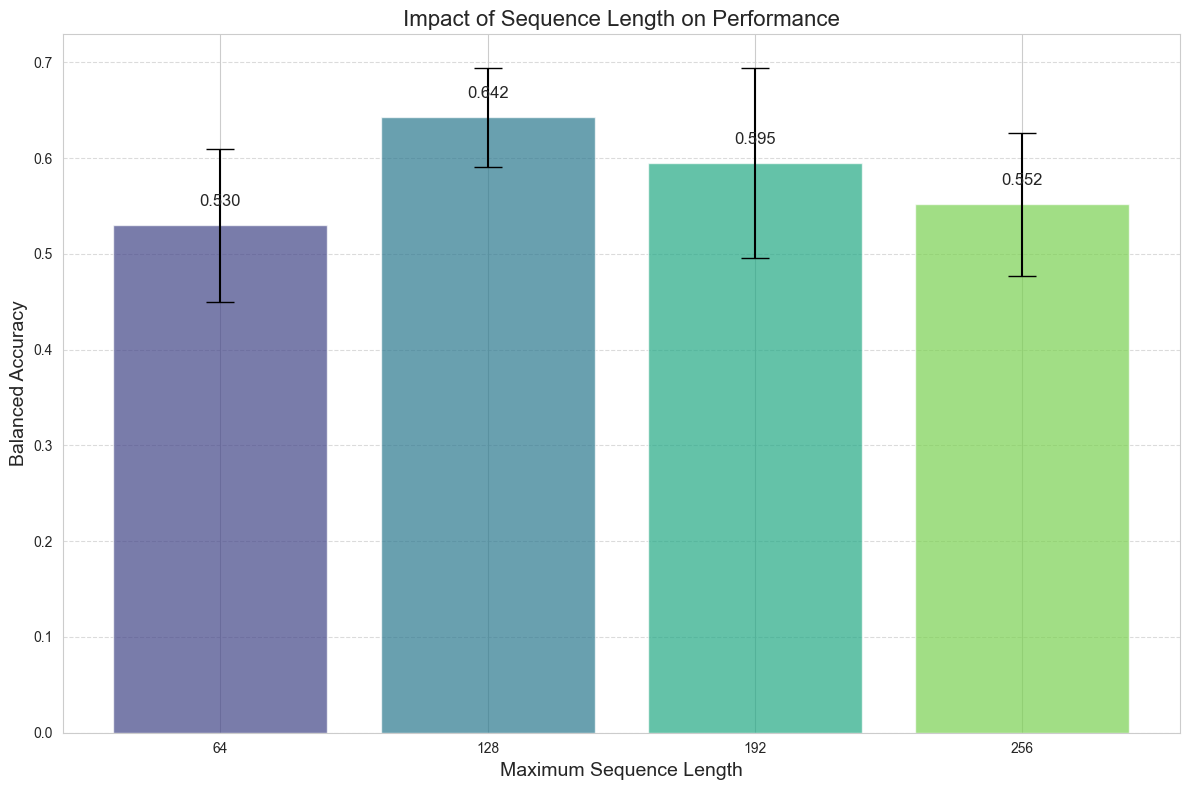

In [28]:
plt.figure(figsize=(12, 8))
seq_length_stats = df.groupby('max_length')['balanced_accuracy'].agg(['mean', 'std']).reset_index()

# Create bar chart with error bars
plt.bar(seq_length_stats['max_length'].astype(str), 
        seq_length_stats['mean'], 
        yerr=seq_length_stats['std'],
        color=sns.color_palette('viridis', len(seq_length_stats)),
        alpha=0.7, capsize=10)

plt.title('Impact of Sequence Length on Performance', fontsize=16)
plt.xlabel('Maximum Sequence Length', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, row in enumerate(seq_length_stats.itertuples()):
    plt.text(i, row.mean + 0.02, f'{row.mean:.3f}', ha='center', fontsize=12)

plt.tight_layout()

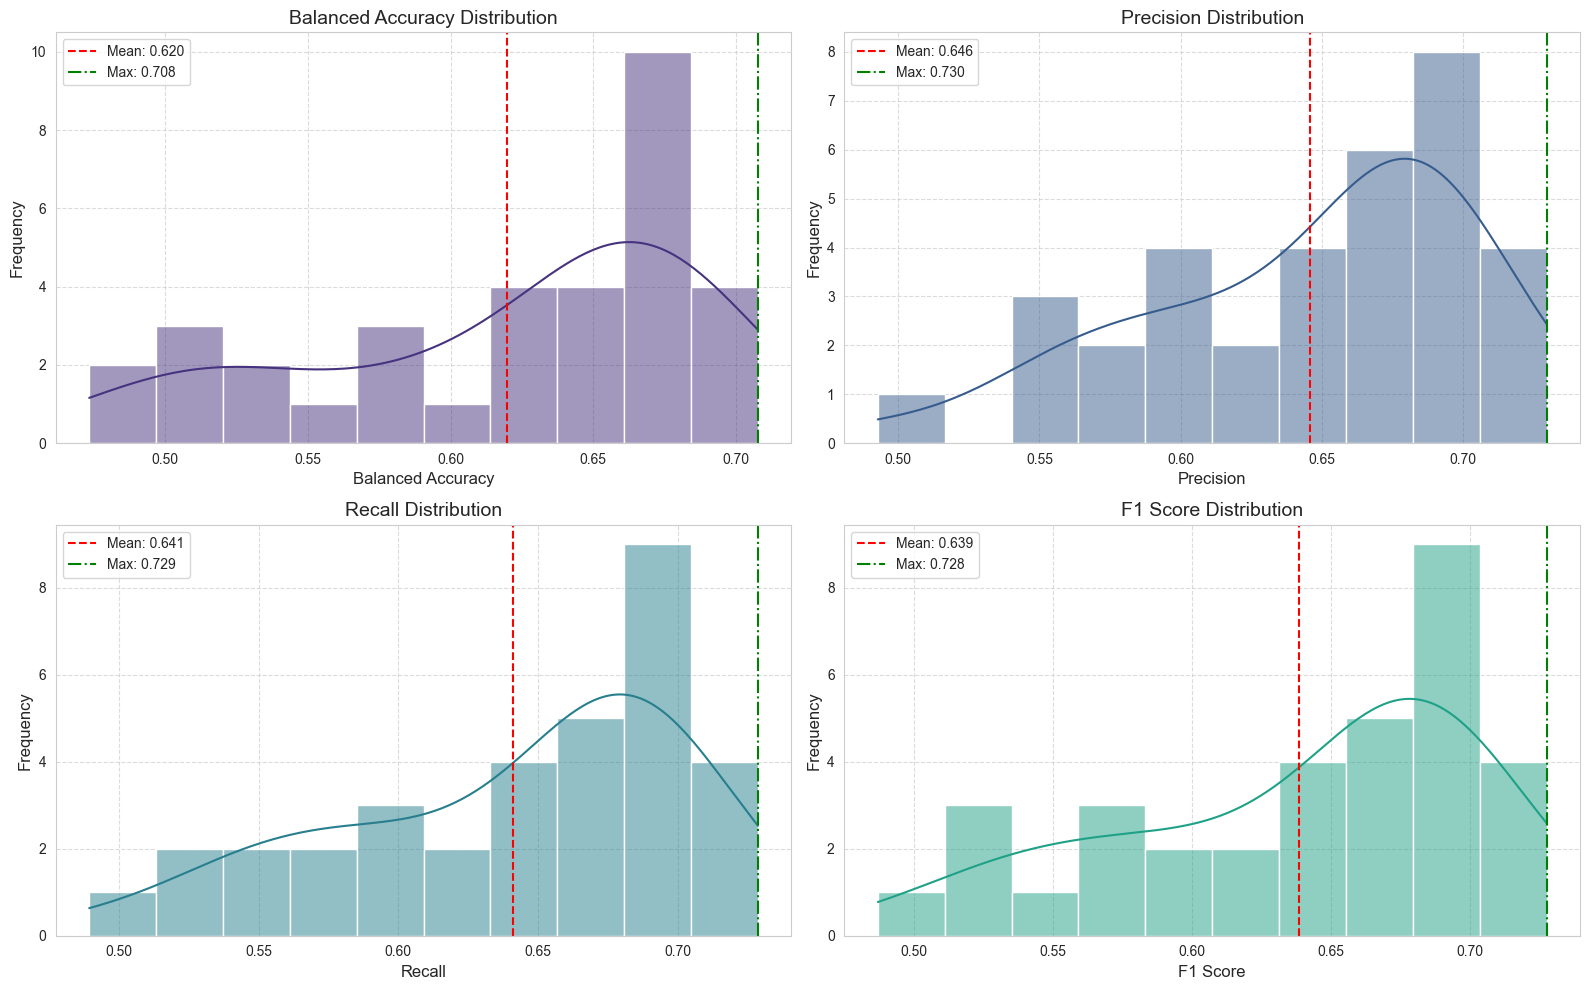

In [29]:
plt.figure(figsize=(16, 10))
metrics = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
metric_labels = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score']

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[metric], kde=True, bins=10, color=sns.color_palette('viridis')[i])
    plt.axvline(x=df[metric].mean(), color='r', linestyle='--',
                label=f'Mean: {df[metric].mean():.3f}')
    plt.axvline(x=df[metric].max(), color='g', linestyle='-.',
                label=f'Max: {df[metric].max():.3f}')
    plt.title(f'{label} Distribution', fontsize=14)
    plt.xlabel(label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

plt.tight_layout()

### Comparison between ModerBERT Base and ModernBERT Large

In [30]:
# Extract relevant data
data = []
for result in results:
    data.append({
        'learning_rate': result['parameters']['learning_rate'],
        'model_name': 'base' if 'base' in result['parameters']['model_name'] else 'large',
        'balanced_accuracy': result['evaluation_results'].get('eval_balanced_accuracy', 0),
        'max_length': result['parameters']['max_length'],
        'num_epochs': result['parameters']['num_epochs'],
        'warmup_ratio': result['parameters']['warmup_ratio'],
        'weight_decay': result['parameters']['weight_decay'],
        'batch_size': result['parameters']['batch_size'],
    })

df = pd.DataFrame(data)

# Filter for results with 3 epochs, batch size 16 and 128 max_length to ensure fair comparison
filtered_df = df[(df['num_epochs'] == 3) & (df['max_length'] == 128) & (df['batch_size'] == 16)]

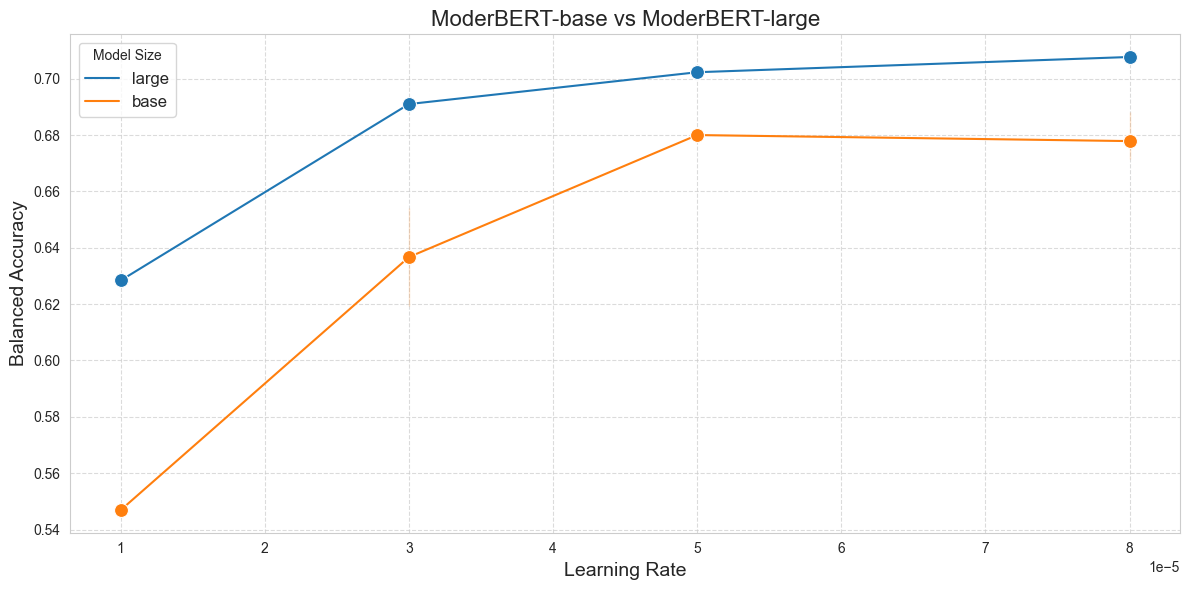

In [31]:
lr_model_counts = pd.crosstab(filtered_df['learning_rate'], filtered_df['model_name'])
valid_lrs = lr_model_counts[lr_model_counts['base'] > 0][lr_model_counts['large'] > 0].index

# Filter the dataframe to only include those learning rates
final_df = filtered_df[filtered_df['learning_rate'].isin(valid_lrs)]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(
    data=final_df, 
    x="learning_rate", 
    y="balanced_accuracy", 
    hue="model_name",
    marker="o", 
    markersize=10
)

plt.title('ModerBERT-base vs ModerBERT-large', fontsize=16)
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.legend(title='Model Size', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Classwise f1-score for top 5 models

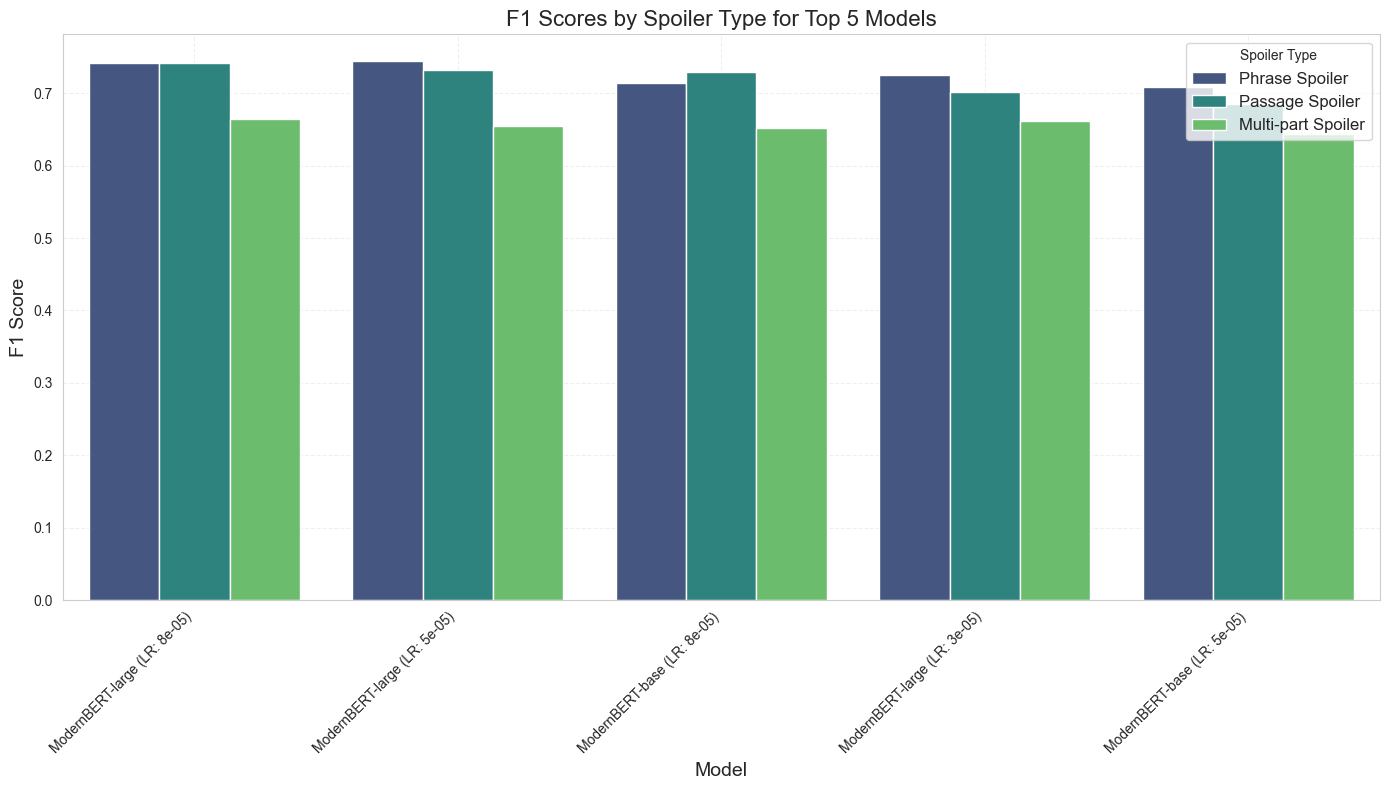

In [32]:
# Extract F1 scores for each class
class_data = []
for result in results:
    if all(f'eval_f1_class_{i}' in result['evaluation_results'] for i in range(3)):
        class_data.append({
            'model': f"{result['parameters']['model_name'].split('/')[-1]} (LR: {result['parameters']['learning_rate']})",
            'class_0': result['evaluation_results']['eval_f1_class_0'],
            'class_1': result['evaluation_results']['eval_f1_class_1'],
            'class_2': result['evaluation_results']['eval_f1_class_2'],
            'balanced_accuracy': result['evaluation_results']['eval_balanced_accuracy'],
        })

class_df = pd.DataFrame(class_data)

# Sort by balanced accuracy
top_5_models = class_df.sort_values('balanced_accuracy', ascending=False).head(5)

# Reshape for seaborn
melted_df = pd.melt(top_5_models, 
                    id_vars=['model', 'balanced_accuracy'], 
                    value_vars=['class_0', 'class_1', 'class_2'],
                    var_name='Spoiler Type', 
                    value_name='F1 Score')

# Map class names to more descriptive labels
melted_df['Spoiler Type'] = melted_df['Spoiler Type'].map({
    'class_0': 'Phrase Spoiler',
    'class_1': 'Passage Spoiler',
    'class_2': 'Multi-part Spoiler'
})

plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_df,
    x='model',
    y='F1 Score',
    hue='Spoiler Type',
    palette='viridis'
)
plt.title('F1 Scores by Spoiler Type for Top 5 Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Spoiler Type', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()